# Checking the effect of including the zeroes
I need to substitute the rainfall and variance estimates made when including zeroes into the data that did not include the zeroes for the four dates in question.

In [1]:
%matplotlib inline
from storm_stats_functions import data_dir, get_data_frame_from_table
from IPython.core.debugger import Tracer
import pandas as pd
import numpy as np

In [2]:
def filter_dates(freq='H'):
    filt_dates = ['2014-09-13', '2015-04-14', '2015-09-30', '2015-10-02']
    l = []
    for d in filt_dates:
        d = pd.to_datetime(d)
        drange = pd.date_range(start=d, end=d+pd.DateOffset(1), freq=freq)
        l.extend(drange)
    return l

In [3]:
wsds = get_data_frame_from_table('wshed_ids')
wsds

fetching data from database for wshed_ids


,level_0,index,ID,Description,arcid,numrem,x,y,Area_sq_km,Area_sq_mi
0,0,0,WS-1,Shore Drive and Great Neck Road,2,3,3.718527e+06,1.068005e+06,0.693451,0.267743
1,1,1,WS-2,Shore Drive and Red Tide Road,4,3,3.711823e+06,1.067229e+06,0.020216,0.007805
2,2,2,WS-3,Ocean View Ave and Mortons Road,1,1,3.715834e+06,1.066781e+06,0.760561,0.293654
3,3,3,WS-4,S. Rosemont and S. Plaza Trail,6,2,3.724698e+06,1.060090e+06,0.083159,0.032108
4,4,4,WS-5,S. Rosemont and Clubhouse,5,2,3.715944e+06,1.066954e+06,0.147142,0.056812
5,5,5,WS-6,21st and Baltic,3,1,3.714183e+06,1.057567e+06,0.258154,0.099674
6,6,6,WS-7,Shore Drive and Kendall Street,0,2,3.714389e+06,1.058331e+06,0.131638,0.050826


(88, 7)
(88, 7)
est    0.211711
var    0.462751
dtype: float64
watershed_descr    0
time_stamp         0
num_removed        0
dtype: int64
               est          var
count  2795.000000  2795.000000
mean      0.006666     0.014570
std       0.088422     0.197891
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       3.163795     5.559594
(88, 7)
(88, 7)
est    0.515315
var    2.185688
dtype: float64
watershed_descr    0
time_stamp         0
num_removed        0
dtype: int64
               est          var
count  2795.000000  2795.000000
mean      0.016225     0.068816
std       0.191437     1.207160
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       0.000000     0.000000
max       5.151870    51.611058
(88, 7)
(88, 7)
est     4.614568
var    12.586053
dtype: float64
watershed_descr    0
time_stamp         0
num_removed        0
dtype: int64
     

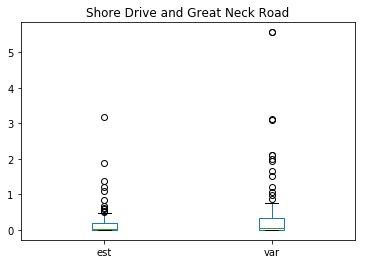

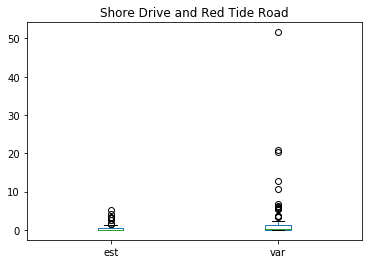

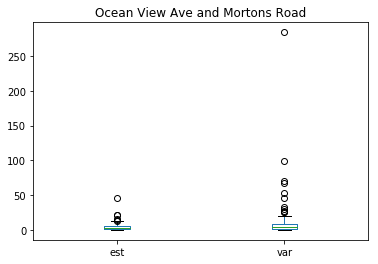

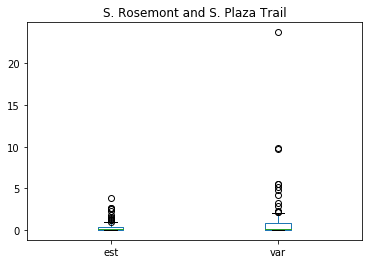

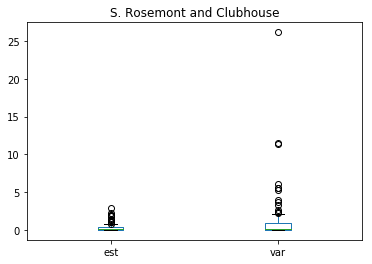

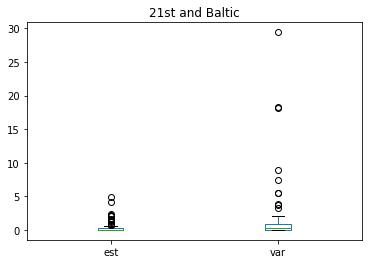

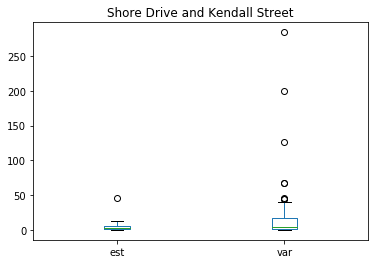

In [20]:
typ = 'hr'
dfz_list = []
dfnz_list = []
for w in wsds.index:
   
    # filtered timestamps
    if typ == 'hr':
        freq = "H"
    if typ == 'fif':
        freq = "15T"
    filtered_dates = filter_dates(freq=freq)

    # read in data with no zeroes
    columns=['watershed_descr', 'time_stamp', 'num_removed', 'dists', 'stations_removed', 'est', 'var']
    if typ == 'fif':
        f_name = '{0}/kriging results/{1}/{1}_{2}.csv'.format(data_dir, typ+"teen_min", wsds.loc[w, 'Description'])
    else:
        f_name = '{0}/kriging results/{1}/{1}_{2}.csv'.format(data_dir, typ, wsds.loc[w, 'Description'])
    df_nz = pd.read_csv(f_name, infer_datetime_format=True, parse_dates=['time_stamp'])
 
    # read in data with zeroes
    f_name = '{0}/kriging results/{1}/{1}_{2}_sel.csv'.format(data_dir, typ + "_zeroes", wsds.loc[w, 'Description'])
    df_z = pd.read_csv(f_name, infer_datetime_format=True, parse_dates=['time_stamp'])
    
    # filter the data by time stamp and num removed
    df_z_filt = df_z[df_z['num_removed'].isin([0, wsds.loc[w, 'numrem']])]
    df_z_filt = df_z_filt[df_z_filt['time_stamp'].isin(filtered_dates)]
    print df_z_filt.shape
    dfz_list.append(df_z_filt)
    
    df_nz_filt = df_nz[df_nz['num_removed'].isin([0, wsds.loc[w, 'numrem']])]
    df_nz_filt = df_nz_filt[df_nz_filt['time_stamp'].isin(filtered_dates)]
    df_nz_ind = df_nz_filt.index
    df_nz_filt.reset_index(inplace=True, drop=True)
    print df_nz_filt.shape
    dfnz_list.append(df_nz_filt)
    
    # compare just on the filter dates
    print abs(df_nz_filt[['est', 'var']] - df_z[['est', 'var']]).mean()
    abs(df_nz_filt[['est', 'var']] - df_z[['est', 'var']]).plot.box(title=wsds.loc[w, 'Description'])

    df_new = pd.concat([df_nz.loc[~df_nz.index.isin(df_nz_ind)], df_z_filt])
    f_name = '{0}/kriging results/{1}/{1}_{2}.csv'.format(data_dir, typ + "_zeroes", wsds.loc[w, 'Description'])
    df_new.to_csv(f_name, index=False)
    
    # compare just on all dates
    df_nz.sort_values(['watershed_descr', 'num_removed', 'time_stamp'], inplace=True)
    df_new.sort_values(['watershed_descr', 'num_removed', 'time_stamp'], inplace=True) 
    df_nz.reset_index(inplace=True, drop=True)
    df_new.reset_index(inplace=True, drop=True)
    print (df_nz.ix[:, :3] != df_new.ix[:, :3]).sum()
    print abs(df_nz[['est', 'var']] - df_new[['est', 'var']]).describe()

## Comparing just the dates on which zero rain was recorded by more than one station

In [21]:
all_z = pd.concat(dfz_list)
all_nz = pd.concat(dfnz_list)
all_z.sort_values(['watershed_descr', 'num_removed', 'time_stamp'], inplace=True)
all_nz.sort_values(['watershed_descr', 'num_removed', 'time_stamp'], inplace=True)
all_z.reset_index(inplace=True, drop=True)
all_nz.reset_index(inplace=True, drop=True)

Making sure all the data lines up

In [22]:
(all_nz.ix[:, :3] != all_z.ix[:, :3]).sum()

watershed_descr    0
time_stamp         0
num_removed        0
dtype: int64

Having a couple of infinity values

In [23]:
all_nz['est'].min()

-0.127680522203

In [24]:
all_z['est'].min()

-0.049535419000000004

In [25]:
a = (abs(all_nz[['est', 'var']] - all_z[['est', 'var']]))
a[a['est'] == np.inf]

,est,var


Take out the infinity values

In [26]:
a[a['est'] != np.inf].describe()

,est,var
count,616.000000,616.000000
mean,0.334131,1.165801
std,0.653596,3.650017
min,0.000000,0.000000
25%,0.006753,0.005091
50%,0.078757,0.109749
75%,0.311764,0.678394
max,5.151870,51.611058


In [9]:
all_nz[['est', 'var']].describe()

,est,var
count,2226.000000,2226.000000
mean,0.733489,0.637305
std,1.039515,2.303616
min,-0.307358,0.000100
25%,0.045402,0.022881
50%,0.392957,0.117706
75%,0.962995,0.441386
max,9.310034,44.353568


In [10]:
all_z[['est', 'var']].describe()

,est,var
count,2226.000000,2226.000000
mean,0.689356,0.466283
std,1.053787,1.554887
min,-0.143330,0.000098
25%,0.029630,0.016507
50%,0.340825,0.094249
75%,0.907959,0.338407
max,9.328411,34.576836
